In [3]:
# Let's make this notebook compatible for Python 2 and 3
from __future__ import division, print_function

# Import libraries
import pandas as pd
import numpy as np
import os
import math
import copy
import progressbar

# for visualization
import matplotlib.pyplot as plt

# to import module from parent directory
import sys
sys.path.append('..')

# Dataset API from sklearn
from sklearn import datasets

In [8]:
import import_ipynb
from decision_tree import ClassificationTree

In [9]:
# Import helper functions
from utils import divide_on_feature, train_test_split, get_random_subsets
from utils import to_categorical, normalize, Plot, accuracy_score, calculate_entropy
from utils.misc import bar_widgets

from deep_learning.activation_functions import Sigmoid, ReLU, SoftPlus, LeakyReLU, TanH, ELU
from deep_learning.loss_functions import CrossEntropy, SquareLoss

In [10]:
class RandomForest():
    """Random Forest classifier. Uses a collection of classification trees that
    trains on random subsets of the data using a random subsets of the features.

    Parameters:
    -----------
    n_estimators: int
        The number of classification trees that are used.
    max_features: int
        The maximum number of features that the classification trees are allowed to
        use.
    min_samples_split: int
        The minimum number of samples needed to make a split when building a tree.
    min_gain: float
        The minimum impurity required to split the tree further. 
    max_depth: int
        The maximum depth of a tree.
    """
    def __init__(self, n_estimators=100, max_features=None, min_samples_split=2,
                 min_gain=0, max_depth=float("inf")):
        self.n_estimators = n_estimators    # Number of trees
        self.max_features = max_features    # Maxmimum number of features per tree
        self.min_samples_split = min_samples_split
        self.min_gain = min_gain            # Minimum information gain req. to continue
        self.max_depth = max_depth          # Maximum depth for tree
        self.progressbar = progressbar.ProgressBar(widgets=bar_widgets)

        # Initialize decision trees
        self.trees = []
        for _ in range(n_estimators):
            self.trees.append(
                ClassificationTree(
                    min_samples_split=self.min_samples_split,
                    min_impurity=min_gain,
                    max_depth=self.max_depth))

    def fit(self, X, y):
        n_features = np.shape(X)[1]
        # If max_features have not been defined => select it as
        # sqrt(n_features)
        if not self.max_features:
            self.max_features = int(math.sqrt(n_features))

        # Choose one random subset of the data for each tree
        subsets = get_random_subsets(X, y, self.n_estimators)

        for i in self.progressbar(range(self.n_estimators)):
            X_subset, y_subset = subsets[i]
            # Feature bagging (select random subsets of the features)
            idx = np.random.choice(range(n_features), size=self.max_features, replace=True)
            # Save the indices of the features for prediction
            self.trees[i].feature_indices = idx
            # Choose the features corresponding to the indices
            X_subset = X_subset[:, idx]
            # Fit the tree to the data
            self.trees[i].fit(X_subset, y_subset)

    def predict(self, X):
        y_preds = np.empty((X.shape[0], len(self.trees)))
        # Let each tree make a prediction on the data
        for i, tree in enumerate(self.trees):
            # Indices of the features that the tree has trained on
            idx = tree.feature_indices
            # Make a prediction based on those features
            prediction = tree.predict(X[:, idx])
            y_preds[:, i] = prediction
            
        y_pred = []
        # For each sample
        for sample_predictions in y_preds:
            # Select the most common class prediction
            y_pred.append(np.bincount(sample_predictions.astype('int')).argmax())
        return y_pred


Training: 100% [-----------------------------------------------] Time:  0:02:10


Accuracy: 0.958217270194986


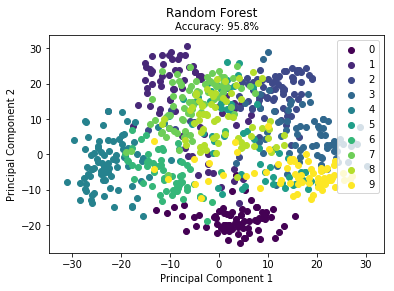

In [11]:
def main():
    data = datasets.load_digits()
    X = data.data
    y = data.target

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, seed=2)

    clf = RandomForest(n_estimators=100)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print ("Accuracy:", accuracy)

    Plot().plot_in_2d(X_test, y_pred, title="Random Forest", accuracy=accuracy, legend_labels=data.target_names)


if __name__ == "__main__":
    main()
